In [1]:
%matplotlib inline
from solveSym import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [13]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = -3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [24]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [25]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [26]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [27]:
# F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

# ls = linearSolve(b, Np, eta)
# ls.RBM(v, o, r, F, T, S, D) 

In [28]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 300.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 1min 24s, sys: 127 ms, total: 1min 24s
Wall time: 1min 24s


'The solver successfully reached the end of the integration interval.'

In [29]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [30]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

In [31]:
plt.rcParams.update({'font.size': 17})

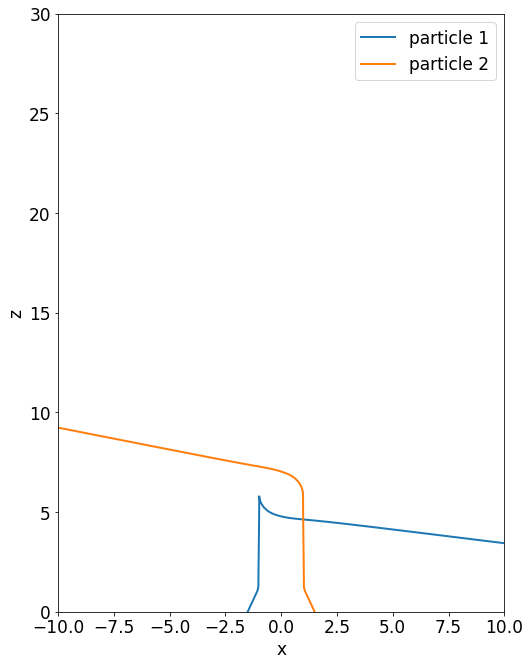

In [32]:
##x-y plot like in Ishikawa
plt.figure(figsize=(8,11))
plt.plot(pos1[:,0], pos1[:,2], label='particle 1', lw=2)
plt.plot(pos2[:,0], pos2[:,2], label='particle 2', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.ylim(0,30)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [33]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(1.9642126728821647, 81.81277573050087)

In [34]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([37]),)

In [35]:
xik,yik,zik ##they go out of plane? not anymore! 

(-1.964038841699164, 6.306848860216265e-11, -0.026131448637680244)

In [37]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [38]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.22044605e-16  2.22044605e-16  1.55431223e-15
  1.28785871e-14  3.57491814e-14  1.01949560e-11  5.29591926e-11
  2.44300136e-11 -4.26381153e-11 -1.31544331e-10 -2.27121433e-10
 -4.03098888e-10 -5.81726223e-10 -7.64137420e-10 -1.14775034e-09
 -1.55463975e-09 -3.14738702e-09 -5.16036969e-09 -7.70971020e-09
 -1.10672944e-08 -1.31404485e-08 -1.54770685e-08 -1.81208066e-08
 -2.11350284e-08 -2.81277712e-08 -3.68690358e-08 -4.76301374e-08
 -6.07296575e-08 -1.03847756e-07 -1.68439115e-07 -2.61901799e-07
 -3.93506266e-07 -5.75001872e-07 -9.04071060e-07 -1.38057481e-06
 -2.06318793e-06 -3.03258018e-06 -5.73050042e-06 -1.05600578e-05
 -1.91141152e-05 -3.41717121e-05  3.45386056e-04 -4.49234164e-03
 -4.90207017e-03]


In [39]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [40]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
       -1.11022302e-16,  3.33066907e-15,  3.83026943e-15,  7.35522754e-14,
        2.72282197e-13,  3.19966276e-13, -8.01292366e-12, -6.40214992e-10,
       -1.48083934e-09, -1.52106111e-09, -1.52488699e-09, -1.53210761e-09,
       -1.55904739e-09, -1.59492292e-09, -1.63516600e-09, -1.72695647e-09,
       -1.83258089e-09, -2.30752173e-09, -2.99841214e-09, -3.94019053e-09,
       -5.21954008e-09, -6.01101996e-09, -6.90076430e-09, -7.89453964e-09,
       -9.00043604e-09, -1.14806369e-08, -1.44435097e-08, -1.79317658e-08,
       -2.19936273e-08, -3.43967236e-08, -5.13145705e-08, -7.38885984e-08,
       -1.03583963e-07, -1.42307498e-07, -2.08916603e-07, -3.01021573e-07,
       -4.28914345e-07, -6.07125352e-07, -1.09408606e-06, -1.95093093e-06,
       -3.44785846e-06, -6.05963755e-06,  5.88769248e-05, -7.55382852e-04,
       -8.23821748e-04])

In [41]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.11022302e-16,
       -1.11022302e-16,  7.21644966e-15,  8.32667268e-15,  1.69420034e-13,
        6.76347867e-13,  9.48574552e-13,  1.98162042e-10,  2.30924846e-09,
        5.56130142e-10,  5.60326896e-10,  5.49906676e-10,  5.40334555e-10,
        5.26730548e-10,  5.15682164e-10,  5.05631759e-10,  4.88548868e-10,
        4.72817119e-10,  4.20886215e-10,  3.61494945e-10,  2.77539436e-10,
        1.43059120e-10,  5.37934142e-11, -5.41101608e-11, -1.81543891e-10,
       -3.30000915e-10, -6.82289225e-10, -1.12822485e-09, -1.67611636e-09,
       -2.33383779e-09, -4.40640457e-09, -7.29084859e-09, -1.11617395e-08,
       -1.62328734e-08, -2.27893566e-08, -3.41166397e-08, -4.97994713e-08,
       -6.98188881e-08, -9.87375492e-08, -1.81487063e-07, -3.23976485e-07,
       -5.72836192e-07, -1.00685108e-06,  9.79743987e-06, -1.25530243e-04,
       -1.36869383e-04])

In [42]:
X.nfev

128

In [43]:
or1[:,0]

array([ 0.42261826,  0.42261578,  0.4226133 ,  0.42258845,  0.42256359,
        0.42231342,  0.42206144,  0.41943691,  0.41660752,  0.41354986,
        0.39233337,  0.35746687,  0.3517791 ,  0.34567933,  0.33924153,
        0.33258804,  0.32013823,  0.30770941,  0.29545957,  0.27214172,
        0.24974843,  0.1796761 ,  0.11998924,  0.07009445,  0.02758574,
        0.00894695, -0.0078507 , -0.022994  , -0.03664111, -0.0593289 ,
       -0.07787589, -0.09306356, -0.10552029, -0.12715401, -0.14078028,
       -0.14929946, -0.15459889, -0.15794206, -0.1604791 , -0.16194636,
       -0.16279913, -0.16328529, -0.16364869, -0.16378194, -0.16385261,
       -0.16389013, -0.16388708, -0.16427198, -0.16430494])

In [44]:
pos1[:,2]

array([0.00000000e+00, 6.64566011e-05, 1.32913282e-04, 7.97487083e-04,
       1.46206885e-03, 8.10859170e-03, 1.47559235e-02, 8.12759138e-02,
       1.47886713e-01, 2.14597851e-01, 5.67687295e-01, 9.26777490e-01,
       9.72252880e-01, 1.01791208e+00, 1.06374478e+00, 1.10972121e+00,
       1.19514198e+00, 1.28083871e+00, 1.36675420e+00, 1.53809623e+00,
       1.70999049e+00, 2.29873217e+00, 2.88915012e+00, 3.47916137e+00,
       4.08894158e+00, 4.40087888e+00, 4.71211345e+00, 5.02263377e+00,
       5.33244181e+00, 5.93030722e+00, 6.52579100e+00, 7.11915427e+00,
       7.71067210e+00, 9.12200349e+00, 1.05270707e+01, 1.19280561e+01,
       1.33264161e+01, 1.47230970e+01, 1.65039979e+01, 1.82839138e+01,
       2.00632598e+01, 2.18422928e+01, 2.48865291e+01, 2.79305689e+01,
       3.09745508e+01, 3.40184999e+01, 4.47175475e+01, 5.54164428e+01,
       5.59360645e+01])